In [ ]:
# 📦 Install and import
!pip install -U spacy textblob --quiet
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 74.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.



📈 Feature Prioritization Based on Test Data:
      Feature  Frequency  AvgSentiment  PriorityScore
0        book       1653         0.158        260.716
2        time       1124         0.151        170.172
6       thing       1130         0.122        137.534
10        way        885         0.154        136.206
1       movie        832         0.149        123.577
3       story        661         0.177        116.722
4        year        552         0.175         96.789
12      music        354         0.236         83.382
19        day        495         0.168         83.178
18        lot        605         0.136         82.159
15       song        328         0.243         79.650
13      album        285         0.238         67.965
16       life        344         0.190         65.307
5     product        379         0.140         52.921
17     review        457         0.110         50.361
9      people        386         0.124         47.983
7   character        401         0.1

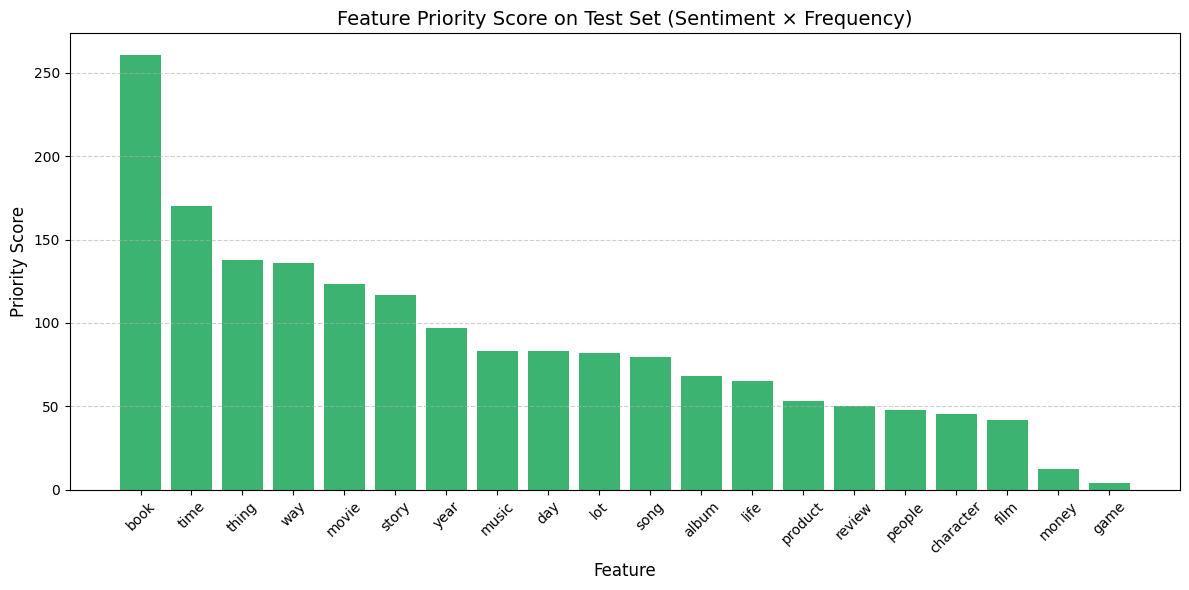

In [ ]:
import pandas as pd
import bz2
import spacy
from textblob import TextBlob
from collections import Counter
import matplotlib.pyplot as plt

# 🧠 Load SpaCy model
nlp = spacy.load("en_core_web_sm")

# 📁 Helper function to load bz2 review data
def read_bz2_file(filepath, limit=10000):
    data = []
    with bz2.open(filepath, 'rt', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i >= limit: break
            try:
                label, text = line.strip().split(' ', 1)
                sentiment = int(label[-1])
                data.append({'SentimentLabel': sentiment, 'Review': text})
            except:
                continue
    return pd.DataFrame(data)

# ⏬ Load train and test sets
df_train = read_bz2_file('/train.ft.txt.bz2', limit=10000)
df_test = read_bz2_file('/test.ft.txt.bz2', limit=5000)

# 💬 Add sentiment scores
df_train['SentimentScore'] = df_train['Review'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_test['SentimentScore'] = df_test['Review'].apply(lambda x: TextBlob(x).sentiment.polarity)

# 🧹 Extract nouns from reviews
def extract_nouns(text):
    doc = nlp(text.lower())
    return [token.lemma_ for token in doc if token.pos_ == 'NOUN' and not token.is_stop and token.is_alpha]

df_train['Tokens'] = df_train['Review'].apply(extract_nouns)
df_test['Tokens'] = df_test['Review'].apply(extract_nouns)

# 📊 Feature extraction from training set
all_nouns_train = [noun for tokens in df_train['Tokens'] for noun in tokens]
noun_freq_train = Counter(all_nouns_train)
top_nouns = [noun for noun, _ in noun_freq_train.most_common(20)]

# 🧠 Score features on test set
feature_scores = []
for noun in top_nouns:
    subset = df_test[df_test['Review'].str.contains(noun, case=False, na=False)]
    freq = len(subset)
    if freq == 0:
        continue
    avg_sentiment = subset['SentimentScore'].mean()
    priority_score = round(freq * avg_sentiment, 3)
    feature_scores.append({
        'Feature': noun,
        'Frequency': freq,
        'AvgSentiment': round(avg_sentiment, 3),
        'PriorityScore': priority_score
    })

ranking_df = pd.DataFrame(feature_scores).sort_values(by='PriorityScore', ascending=False)
print("\n📈 Feature Prioritization Based on Test Data:")
print(ranking_df)

# 📤 Optional: Export
ranking_df.to_csv("amazon_feature_priority_test_scored.csv", index=False)

# 📉 Visualization
plt.figure(figsize=(12, 6))
plt.bar(ranking_df['Feature'], ranking_df['PriorityScore'], color='mediumseagreen')
plt.title('Feature Priority Score on Test Set (Sentiment × Frequency)', fontsize=14)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Priority Score', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

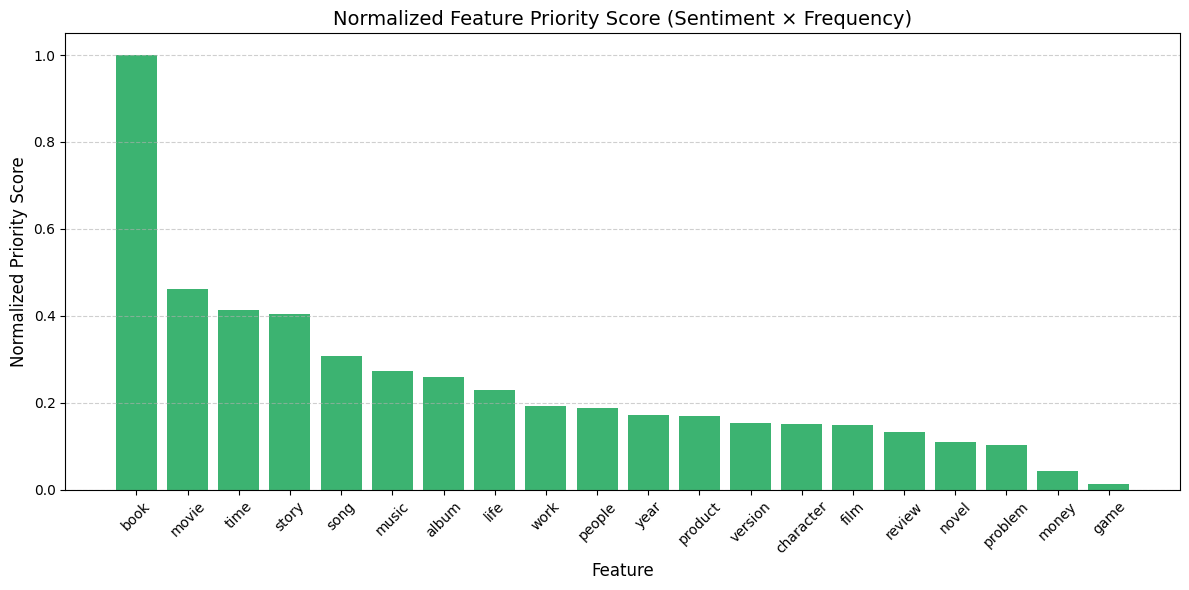

In [2]:
import numpy as np

# 🧹 Step 1: Filter out generic nouns using a custom stoplist
GENERIC_NOUNS = {'thing', 'way', 'lot', 'stuff', 'item', 'part', 'something', 'anything', 'everything'}

# 🧠 Step 2: Use noun chunks instead of single nouns
def extract_noun_phrases(text):
    doc = nlp(text.lower())
    return [chunk.root.lemma_ for chunk in doc.noun_chunks
            if chunk.root.pos_ == 'NOUN'
            and not chunk.root.is_stop
            and chunk.root.is_alpha
            and chunk.root.lemma_ not in GENERIC_NOUNS]

df_train['Tokens'] = df_train['Review'].apply(extract_noun_phrases)
df_test['Tokens'] = df_test['Review'].apply(extract_noun_phrases)

# 🧱 Step 3: Token string for accurate matching
df_test['TokenStr'] = df_test['Tokens'].apply(lambda x: ' '.join(x))

# 🏗️ Step 4: Extract top N features from training set
all_nouns_train = [noun for tokens in df_train['Tokens'] for noun in tokens]
noun_freq_train = Counter(all_nouns_train)
top_nouns = [noun for noun, _ in noun_freq_train.most_common(20)]

# 📈 Step 5: Score features on test set
feature_scores = []
for noun in top_nouns:
    subset = df_test[df_test['TokenStr'].str.contains(rf'\b{noun}\b', na=False)]
    freq = len(subset)
    if freq == 0:
        continue
    avg_sentiment = subset['SentimentScore'].mean()
    priority_score = round(freq * avg_sentiment, 3)
    feature_scores.append({
        'Feature': noun,
        'Frequency': freq,
        'AvgSentiment': round(avg_sentiment, 3),
        'PriorityScore': priority_score
    })

ranking_df = pd.DataFrame(feature_scores).sort_values(by='PriorityScore', ascending=False)

# 🔧 Step 6: Normalize Priority Score (0–1)
max_score = ranking_df['PriorityScore'].max()
ranking_df['NormalizedScore'] = (ranking_df['PriorityScore'] / max_score).round(3)

# 📤 Step 7: Export & Visualize
ranking_df.to_csv("amazon_feature_priority_test_scored_improved.csv", index=False)

# 📉 Bar Chart
plt.figure(figsize=(12, 6))
plt.bar(ranking_df['Feature'], ranking_df['NormalizedScore'], color='mediumseagreen')
plt.title('Normalized Feature Priority Score (Sentiment × Frequency)', fontsize=14)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Normalized Priority Score', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
